<a href="https://colab.research.google.com/github/HsiuWen/DL_course_MS_HPC_IA/blob/new_lab/L1b_what_NN_see_input.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook has been prepared by Hsiu-Wen (Kelly) Chang from MINES ParisTech.



# What a neural network is looking for in the image?

We had tried to see the values of trained values in the first layer in order to explain the reason why NN can solve the problem. But we can't see the where and why NN thinks it is the answer we want as ouput. 

Here is way that can explain more NN's decision and also satisfy scientific curiosity. We call it **Saliency Maps**

## What are Saliency Maps?

They are heatmaps that highlights pixels of the input images that most caused the output classification. Therefore, it has the same dimension of the input image so we can project this map on theh input image in order to understand how NN solve the problem in a more intuitive way.

Recall the way NN decides the class score (probabilities of the class) at the final output, if we want to know how the input image pixels contribut to this score, we can trace back the graident of the output class score with respect to the input image pixels values. 

* The pixels for which this griendt would be large are the pixels that need to be changed **the least** to affect the class socre **the most**

You can also say the such pixels correspond to the object's location in the image

## Saliency map extraction in Pytorch

### 0. Configuration

In [1]:
import sys
print('Your python version: {}'.format(sys.version_info.major))

# The best way to make sure your installaion of pytorch match 
# the system of your computer, check https://pytorch.org/

#!conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch


Your python version: 3


In [2]:
%matplotlib inline
import os
from numpy import newaxis

import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
#from torchsummary import summary
import requests
from PIL import Image

### 1. Download test images

In [44]:
def download(url,fname):
    response = requests.get(url)
    with open(fname,"wb") as f:
        f.write(response.content)
    
# Downloading the image    
download("https://specials-images.forbesimg.com/imageserve/5db4c7b464b49a0007e9dfac/960x0.jpg?fit=scale","input.jpg")
download("https://cdn.shopify.com/s/files/1/1276/8957/products/Platia_Fountain_Garden_Water_Fountain.jpg?v=1536335247","input2.jpg")
download("https://images.all-free-download.com/images/graphicthumb/fountains_03_hd_picture_166254.jpg", "input3.jpg")
# Opening the image
img = Image.open('input3.jpg') 

### 2. Preprocessing of input

We are going to use VGG as our ConvNet. The input size of image used in this base model is 224x224 and therefore we need to resize the image to match it. Then we convert image from PIL Image (Height x Width x Channels, range [2,255]) to PyTorch tensor (Channels x Height x Width, [0,1]). Overall, the processes we are going to do include: 

* Resize image
* Switch the order of channel
* Normalize it using mean and standard deviation according to ImageNet dataset


In [45]:
# --------------------------------------
# Image preprocessing
# --------------------------------------
def preprocess(image, size = 224):
    transform = T.Compose([
        T.Resize((size,size)),
        T.ToTensor(),
        T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229,0.224,0.225]),
        T.Lambda(lambda x: x[None]),
    ])
    return transform (image)

def deprocess(image):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
        T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        T.ToPILImage(),
    ])
    return transform(image)

def show_img(PIL_IMG):
    plt.imshow(np.asarray(PIL_IMG))

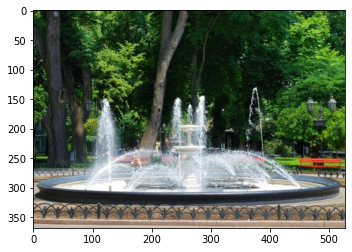

In [46]:
show_img(img)

### 2. Review of VGG-19

First step, we will load ConvNet VGG-19 that is pre-trained on ImageNet.

![](https://discuss.pytorch.org/uploads/default/original/3X/c/9/c9862aa4348056b51f84f8bcceb28f71116c9733.png)

As we can see that it outputs 1000 classes of objects. To interpret the name of each object, Download ImageNet lable

In [6]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

print(categories)

--2021-02-12 11:06:07--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt.4’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0.005s  

2021-02-12 11:06:07 (2.09 MB/s) - ‘imagenet_classes.txt.4’ saved [10472/10472]

['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house finch', 'junco', 'indigo bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water ouzel', 'kite', 'bald eagle', 'vulture', 'great grey owl', 'European fire salamander', 'common newt', 'eft', 'spotted salamander', 'axolotl', 'bullf

Now we can see what are the top possible labels of this image:

In [47]:
# Preprocess the image
X = preprocess(img)


#Using VGG-19 pretrained model for image classification
model = torchvision.models.vgg19(pretrained=True)

# Disable the memory of gradient for each parameters since there is no training
for param in model.parameters():
    param.requires_grad = False
    
# Run the model in the evalution mode instead of training mode
model.eval()

# Set input tensor X to record the gradient with respect to the input image
X.requires_grad_()

#Forward pass through the model to get the score
scores = model(X)


In [48]:
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(scores[0], dim=0)

# Show top 5 categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

fountain 0.9999299049377441
fireboat 2.2573029127670452e-05
lakeside 1.207346394949127e-05
geyser 6.0909496824024245e-06
palace 4.487686510401545e-06


### 3. Saliency map 

### 3.1 Tensor

Tensor is a node of computation. In another words, it is like the neuron in neural networks (NNs). NNs are a collection of nested functions that are executd on some input data, for example, y = f3(f2(f1(x)+b1)+b2)+b3. These functions defined by parameters (consisting weights and biases), which in Pytorch are stored in tensors. These tensors are very helpful in NNs training since ```torch.autograd``` will help us calculates gradients and stores them in the respective tensors's ```.grad``` attribute

Here is an example how it works:
$$Q=3a^3-b^2$$ 
$$\frac{dQ}{da}=9a^2$$
$$\frac{dQ}{db}=-2b$$

In [4]:
# Assum the loss function is Q, a and b are the input tensors 
# (or you can see it as the tensors in the previous layer)
a = torch.tensor([2.,3.], requires_grad = True)
b = torch.tensor([6.,4.], requires_grad = True)
Q = 3*a**3 - b**2
# When we can Q.backward(), autograd will get dQ/da and dQ/db for you!
# To valify this operation, we need to explicitly pass a gradient argument 
# because it is a vector .gradient is a tensor of the same shape of Q and
# it represents the gradient of Q w.r.t. itself
external_grad = torch.tensor([1., 1.])
Q.backward(gradient = external_grad)
# check if collected gradients are correct
print(9*a**2 == a.grad)
print(-2*b == b.grad)

tensor([True, True])
tensor([True, True])


Now let's get back to our image. Before we calculate the gradient of the maximum score value with respect tot eh input image, we should note that there are 3 channels (RGB) and there are going to have 3 maxmimum vlaues. To derive single class saliency value for each pixel (i, j), we take the maximum magnitude across all color channels.


In [49]:
# Get the index corresponding to the maximum score and the maximum score itself.
score_max_index = scores.argmax()
score_max = scores[0,score_max_index]

'''
backward function on score_max performs the backward pass in the computation graph and calculates the gradient of 
score_max with respect to nodes in the computation graph
'''
score_max.backward()

'''
Saliency would be the gradient with respect to the input image now. But note that the input image has 3 channels,
R, G and B. To derive a single class saliency value for each pixel (i, j),  we take the maximum magnitude
across all colour channels.
'''
saliency, _ = torch.max(X.grad.data.abs(),dim=1)

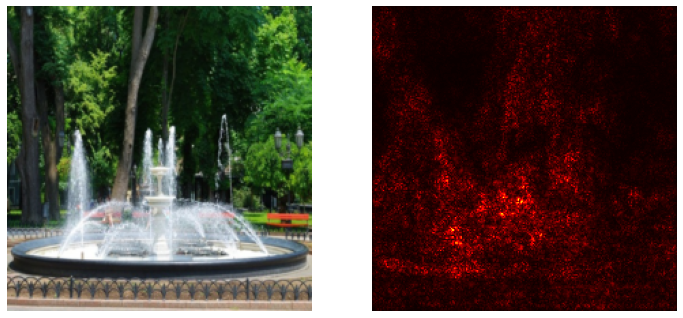

In [50]:
# For visualization purpose, we resize the original image to match the size of saliency map
transform2 = T.Resize((224, 224))
img2 = transform2(img)

f, axarr = plt.subplots(1,2, figsize = (12,12))

axarr[0].imshow(img2)
axarr[1].imshow(saliency[0], cmap=plt.cm.hot)
axarr[0].axis('off')
axarr[1].axis('off')

plt.show()

### 4. Discussion

Change to input2.jpg that you should find a good explanation why the network fail to detect it as fountain and you can compare input3.jpg to validate the guess